## Load/import packages

In [6]:
import time
import scipy.sparse
import numpy as np
import tensorflow as tf

from tensorflow.keras import Sequential, layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg19 import preprocess_input

# Limit GPU memory usage
for device in tf.config.experimental.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(device, True)

## Functions

In [2]:
def feature_extractor(model, data_dir, batch_size=128, test=False):

    # Define ImageDataGenerator with precoessing function set to preprocess_input for vgg19 model
    # Also using class_model categorical which automatically one-hot encodes the labels
    if test == False:
        datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
        generator = datagen.flow_from_directory(
            directory=data_dir,
            target_size=(112, 112),
            color_mode="rgb",
            class_mode="categorical",
            batch_size=batch_size,
            shuffle=False,
        )
    else:
        datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
        generator = datagen.flow_from_directory(
            directory=data_dir,
            target_size=(112, 112),
            color_mode="rgb",
            class_mode=None,
            batch_size=batch_size,
            shuffle=False,
        )
    
    # Grab all filenames in the generator
    filenames = generator.filenames

    # Reset batch index to 0 for the train_generator
    generator.reset()

    # Onehot encoding of labels
    if test == False:
        labels_arr = to_categorical(generator.classes)

    # Create list for the predictions, using list is more memory efficient then concatenating an array each time
    # when adding the new batch into it.
    features = []

    start = time.time()

    if test == False:
        for batch, label in generator:
            pred = model.predict(batch, verbose=0)
            features.append(scipy.sparse.csr_matrix(pred))

            print(
                f"Progress: {round(((generator.total_batches_seen/len(generator))*100),2)}%"
            )
            # Allow loop to break when it has looped over all the batches in the generator, else it will keep looping over them.
            if len(generator) == generator.total_batches_seen:
                break
    else:
        for batch in generator:
            pred = model.predict(batch, verbose=0)
            features.append(scipy.sparse.csr_matrix(pred))

            print(
                f"Progress: {round(((generator.total_batches_seen/len(generator))*100),2)}%"
            )
            # Allow loop to break when it has looped over all the batches in the generator, else it will keep looping over them.
            if len(generator) == generator.total_batches_seen:
                break

    # Stack features in scipy CSR matrix
    features_arr = scipy.sparse.vstack(features)

    seconds = round(time.time() - start, 2)
    print(f"Finished with extraction, Execution duration: {seconds//60}m:{seconds%60}s")

    if test == False:
        return features_arr, labels_arr, filenames
    else:
        return features_arr, filenames

# Initiate Base CNN
For the feature extraction the pre-trained **VGG19** network will be used with the imagenet weights. Input shape is set to 112,112,3. The top is not included because we only want to extract features, so we remove the classification layers.

In [7]:
base_VGG19 = tf.keras.applications.VGG19(
    include_top=False, weights="imagenet", input_shape=(112, 112, 3)
)

In [8]:
base_VGG19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 112, 112, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 112, 112, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 56, 56, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 56, 56, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 56, 56, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 28, 28, 128)       0     

# Initiate Feature Extraction model

In [9]:
# We add a flatten layer to the base VGG19 layer to just get a simple 1-Dimensional feature vector as output for our RNN/LSTM as input
def build_FE_model():
    model = Sequential()
    for layer in base_VGG19.layers:
        model.add(layer)
    model.add(layers.Flatten(name="Flatten"))
    return model

FE_model = build_FE_model()
FE_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 112, 112, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 112, 112, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 56, 56, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 56, 56, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 56, 56, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 28, 28, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 28, 28, 256)      

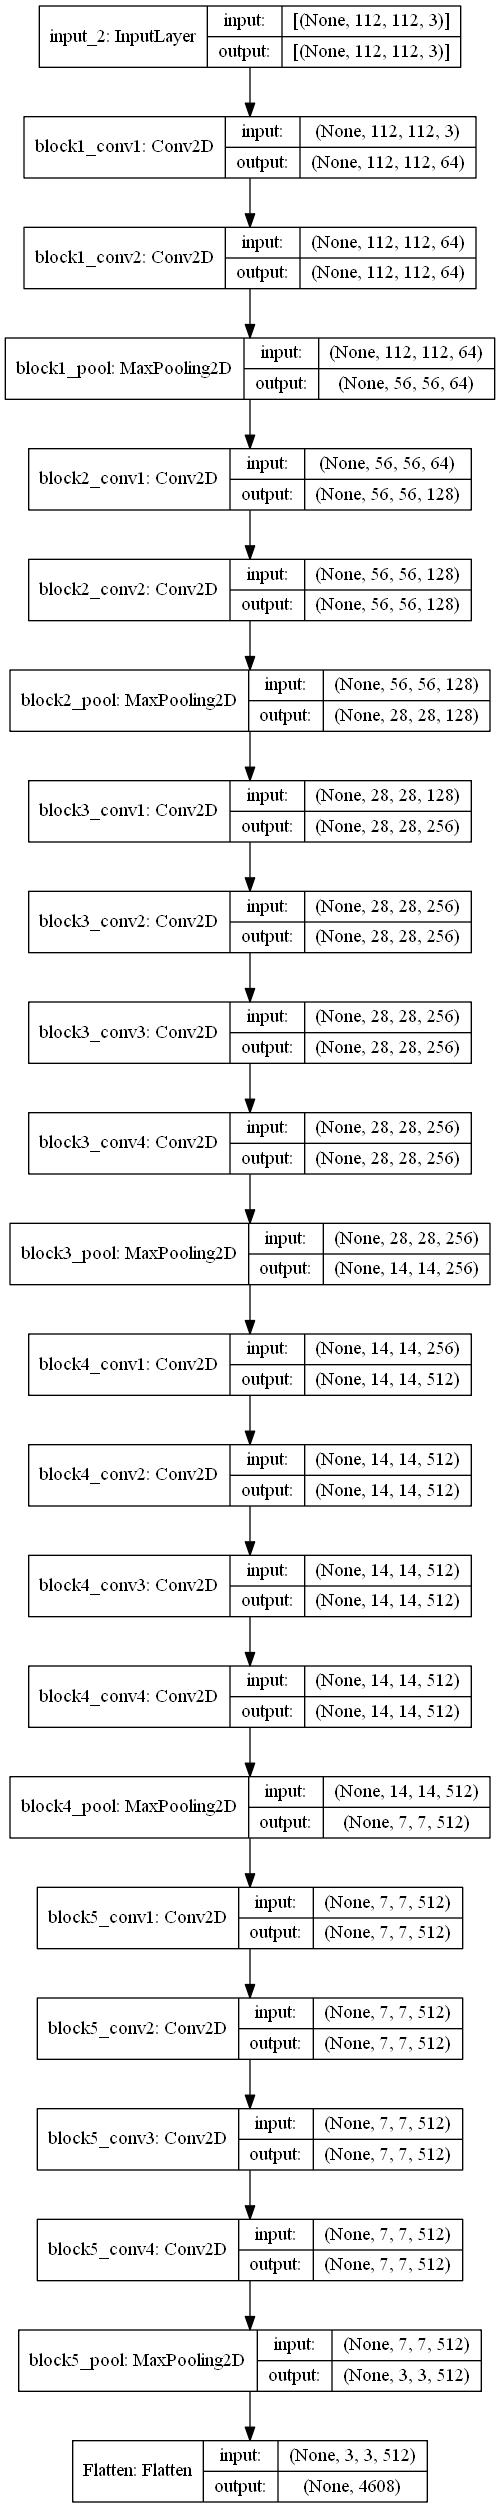

In [11]:
# Plot model
tf.keras.utils.plot_model(
    FE_model,
    to_file=f"data/model_architectures/FE_model.jpg",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [15]:
# Remove block 5 from FE model 
# (Source: Ravi, A. (2018). Pre-Trained Convolutional Neural Network Features for Facial Expression Recognition. ArXiv:1812.06387 [Cs]. 
#  Retrieved from http://arxiv.org/abs/1812.06387)

# Extract all Features with FE model1 - AFF-Wild2

In [7]:
AW2_train_dir = r"D:\Aff-Wild2 Dataset\Aff-wild2\Sets_per_class_RGB\train"
AW2_val_dir = r"D:\Aff-Wild2 Dataset\Aff-wild2\Sets_per_class_RGB\val"

# In this directory each video folder contains all its frames
AW2_test_dir = r"D:\Aff-Wild2 Dataset\Aff-wild2\Sets_RGB\test"

## Extract Training set Features

In [8]:
# Extract training features and labels
train_features, train_labels, train_filenames = feature_extractor(
    FE_model, AW2_train_dir
)

Found 922029 images belonging to 7 classes.
Progress: 0.01%
Progress: 0.03%
Progress: 0.04%
Progress: 0.06%
Progress: 0.07%
Progress: 0.08%
Progress: 0.1%
Progress: 0.11%
Progress: 0.12%
Progress: 0.14%
Progress: 0.15%
Progress: 0.17%
Progress: 0.18%
Progress: 0.19%
Progress: 0.21%
Progress: 0.22%
Progress: 0.24%
Progress: 0.25%
Progress: 0.26%
Progress: 0.28%
Progress: 0.29%
Progress: 0.31%
Progress: 0.32%
Progress: 0.33%
Progress: 0.35%
Progress: 0.36%
Progress: 0.37%
Progress: 0.39%
Progress: 0.4%
Progress: 0.42%
Progress: 0.43%
Progress: 0.44%
Progress: 0.46%
Progress: 0.47%
Progress: 0.49%
Progress: 0.5%
Progress: 0.51%
Progress: 0.53%
Progress: 0.54%
Progress: 0.56%
Progress: 0.57%
Progress: 0.58%
Progress: 0.6%
Progress: 0.61%
Progress: 0.62%
Progress: 0.64%
Progress: 0.65%
Progress: 0.67%
Progress: 0.68%
Progress: 0.69%
Progress: 0.71%
Progress: 0.72%
Progress: 0.74%
Progress: 0.75%
Progress: 0.76%
Progress: 0.78%
Progress: 0.79%
Progress: 0.81%
Progress: 0.82%
Progress: 0.83%


In [9]:
# Save features as NPZ Numpy’s compressed array format and labels as numpy
scipy.sparse.save_npz("data/features/train_features_RGB_AW2.npz", train_features)
np.save("data/labels/train_labels_RGB_AW2.npy", train_labels)
with open("data/filenames/train_filenames_RGB_AW2.txt", "w") as fp:
    fp.write("\n".join(train_filenames))

## Extract Validation set Features

In [10]:
# Extract validation features and labels
val_features, val_labels, val_filenames = feature_extractor(FE_model, AW2_val_dir)

Found 319323 images belonging to 7 classes.
Progress: 0.04%
Progress: 0.08%
Progress: 0.12%
Progress: 0.16%
Progress: 0.2%
Progress: 0.24%
Progress: 0.28%
Progress: 0.32%
Progress: 0.36%
Progress: 0.4%
Progress: 0.44%
Progress: 0.48%
Progress: 0.52%
Progress: 0.56%
Progress: 0.6%
Progress: 0.64%
Progress: 0.68%
Progress: 0.72%
Progress: 0.76%
Progress: 0.8%
Progress: 0.84%
Progress: 0.88%
Progress: 0.92%
Progress: 0.96%
Progress: 1.0%
Progress: 1.04%
Progress: 1.08%
Progress: 1.12%
Progress: 1.16%
Progress: 1.2%
Progress: 1.24%
Progress: 1.28%
Progress: 1.32%
Progress: 1.36%
Progress: 1.4%
Progress: 1.44%
Progress: 1.48%
Progress: 1.52%
Progress: 1.56%
Progress: 1.6%
Progress: 1.64%
Progress: 1.68%
Progress: 1.72%
Progress: 1.76%
Progress: 1.8%
Progress: 1.84%
Progress: 1.88%
Progress: 1.92%
Progress: 1.96%
Progress: 2.0%
Progress: 2.04%
Progress: 2.08%
Progress: 2.12%
Progress: 2.16%
Progress: 2.2%
Progress: 2.24%
Progress: 2.28%
Progress: 2.32%
Progress: 2.36%
Progress: 2.4%
Progress

In [11]:
# Save features as NPZ Numpy’s compressed array format and labels as numpy
scipy.sparse.save_npz("data/features/val_features_RGB_AW2.npz", val_features)
np.save("data/labels/val_labels_RGB_AW2.npy", val_labels)
with open("data/filenames/val_filenames_RGB_AW2.txt", "w") as fp:
    fp.write("\n".join(val_filenames))

## Extract Test set Features


In [12]:
test_features, test_filenames = feature_extractor(FE_model, AW2_test_dir, test=True)

Found 1110211 images belonging to 241 classes.
Progress: 0.01%
Progress: 0.02%
Progress: 0.03%
Progress: 0.05%
Progress: 0.06%
Progress: 0.07%
Progress: 0.08%
Progress: 0.09%
Progress: 0.1%
Progress: 0.12%
Progress: 0.13%
Progress: 0.14%
Progress: 0.15%
Progress: 0.16%
Progress: 0.17%
Progress: 0.18%
Progress: 0.2%
Progress: 0.21%
Progress: 0.22%
Progress: 0.23%
Progress: 0.24%
Progress: 0.25%
Progress: 0.27%
Progress: 0.28%
Progress: 0.29%
Progress: 0.3%
Progress: 0.31%
Progress: 0.32%
Progress: 0.33%
Progress: 0.35%
Progress: 0.36%
Progress: 0.37%
Progress: 0.38%
Progress: 0.39%
Progress: 0.4%
Progress: 0.42%
Progress: 0.43%
Progress: 0.44%
Progress: 0.45%
Progress: 0.46%
Progress: 0.47%
Progress: 0.48%
Progress: 0.5%
Progress: 0.51%
Progress: 0.52%
Progress: 0.53%
Progress: 0.54%
Progress: 0.55%
Progress: 0.56%
Progress: 0.58%
Progress: 0.59%
Progress: 0.6%
Progress: 0.61%
Progress: 0.62%
Progress: 0.63%
Progress: 0.65%
Progress: 0.66%
Progress: 0.67%
Progress: 0.68%
Progress: 0.69%

In [13]:
# Save features as NPZ Numpy’s compressed array format
scipy.sparse.save_npz("data/features/test_features_RGB_AW2.npz", test_features)
with open("data/filenames/test_filenames_RGB_AW2.txt", "w") as fp:
    fp.write("\n".join(test_filenames))

# Extract all Features with FE model1 - AFEW 7.0

In [6]:
AF7_dir = r"D:\AFEW 7.0 Dataset\Val+train_faces"

In [7]:
# Extract train+val features and labels
AF7_features, AF7_labels, AF7_filenames = feature_extractor(FE_model, AF7_dir)

Found 66727 images belonging to 7 classes.
Progress: 0.19%
Progress: 0.38%
Progress: 0.57%
Progress: 0.77%
Progress: 0.96%
Progress: 1.15%
Progress: 1.34%
Progress: 1.53%
Progress: 1.72%
Progress: 1.92%
Progress: 2.11%
Progress: 2.3%
Progress: 2.49%
Progress: 2.68%
Progress: 2.87%
Progress: 3.07%
Progress: 3.26%
Progress: 3.45%
Progress: 3.64%
Progress: 3.83%
Progress: 4.02%
Progress: 4.21%
Progress: 4.41%
Progress: 4.6%
Progress: 4.79%
Progress: 4.98%
Progress: 5.17%
Progress: 5.36%
Progress: 5.56%
Progress: 5.75%
Progress: 5.94%
Progress: 6.13%
Progress: 6.32%
Progress: 6.51%
Progress: 6.7%
Progress: 6.9%
Progress: 7.09%
Progress: 7.28%
Progress: 7.47%
Progress: 7.66%
Progress: 7.85%
Progress: 8.05%
Progress: 8.24%
Progress: 8.43%
Progress: 8.62%
Progress: 8.81%
Progress: 9.0%
Progress: 9.2%
Progress: 9.39%
Progress: 9.58%
Progress: 9.77%
Progress: 9.96%
Progress: 10.15%
Progress: 10.34%
Progress: 10.54%
Progress: 10.73%
Progress: 10.92%
Progress: 11.11%
Progress: 11.3%
Progress: 11.

In [8]:
# Save features as NPZ Numpy’s compressed array format and labels as numpy
scipy.sparse.save_npz("data/features/features_RGB_AF7.npz", AF7_features)
np.save("data/labels/labels_RGB_AF7.npy", AF7_labels)
with open("data/filenames/filenames_RGB_AF7.txt", "w") as fp:
    fp.write("\n".join(AF7_filenames))